In [1]:
from pyspark.sql.functions import isnan, when, count, col, countDistinct, mean, stddev
import pandas as pd
import numpy as np
from pyspark.ml.feature import FeatureHasher, Tokenizer, RegexTokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum as _sum
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
sqlc=SQLContext(sc)

train_df = spark.read.json('/FileStore/tables/RS_v2_2006_03.json')
test_df = spark.read.json('/FileStore/tables/RS_v2_2006_04')
oot_df = spark.read.json('/FileStore/tables/RS_v2_2006_05')

# 1. EDA

## 1.1. Explore 'subreddit'

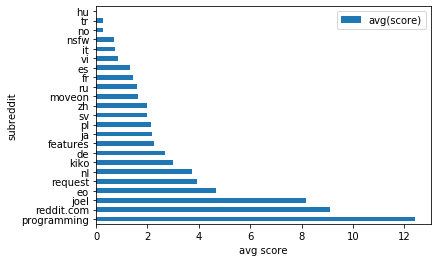

In [4]:
train_df.registerTempTable('train_df')
sqlc.sql("SELECT subreddit, AVG(score), MIN(score), MAX(score), COUNT(score) FROM train_df GROUP BY subreddit ORDER BY AVG(score) DESC").toPandas()

df1 = sqlc.sql("SELECT subreddit, AVG(score)FROM train_df GROUP BY subreddit ORDER BY AVG(score) DESC").toPandas()
df1.plot(kind='barh',x='subreddit',y='avg(score)')
plt.xlabel('avg score')
plt.show()

## 1.2. Explore 'author'

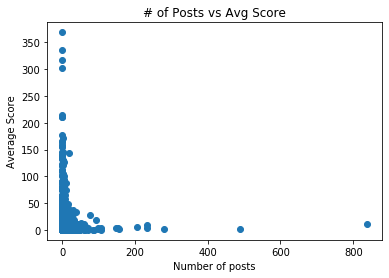

In [6]:
df2 = sqlc.sql("SELECT author, AVG(score), MIN(score), MAX(score), COUNT(score) FROM train_df GROUP BY author ORDER BY COUNT(score) DESC").toPandas()
plt.scatter(df2['count(score)'],df2['avg(score)'])
plt.xlabel('Number of posts')
plt.ylabel('Average Score')
plt.title('# of Posts vs Avg Score')
plt.show()

## 1.3. Explore 'num_comments'

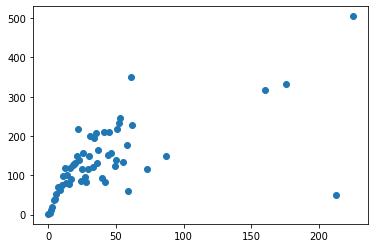

In [8]:
df3 = sqlc.sql("SELECT num_comments, AVG(score) FROM train_df GROUP BY num_comments ORDER BY AVG(score) DESC LIMIT 59").toPandas()
plt.scatter(df3['num_comments'],df3['avg(score)'])
plt.xlabel = 'Number of Comments'
plt.ylabel = 'Average Score'
plt.title = 'Number of Comments vs Avg Score'
plt.show()

## 1.4. Explore 'domain'

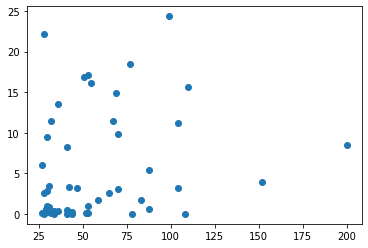

In [10]:
df4 = sqlc.sql("SELECT domain, AVG(score), MIN(score), MAX(score), COUNT(score) FROM train_df GROUP BY domain ORDER BY COUNT(score) DESC LIMIT 50").toPandas()
plt.scatter(df4['count(score)'],df4['avg(score)'])
plt.xlabel = 'Number of times a domain appears'
plt.ylabel = 'Average Score'
plt.title = 'Domain vs Avg Score'
plt.show()

## 1.5. Drop 'author' and 'domain'

In [12]:
train_df2 = train_df.drop('author','domain')

# 2. Data Preprocessing

## 2.1 Drop columns with substantial null values
This step is to drop columns with only null values since they are meaningless for making predictions.

In [15]:
# count the total number of rows
print('Total # of rows:',train_df2.select('archived').count())

Total # of rows: 12525

In [16]:
# count the number of null values in each column
display(train_df2.select([count(when(col(c).isNull(), c)).alias(c) for c in train_df2.columns]))

archived,author_cakeday,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_text_color,author_flair_type,brand_safe,can_gild,contest_mode,created_utc,distinguished,edited,gilded,hidden,hide_score,id,is_crosspostable,is_reddit_media_domain,is_self,is_video,link_flair_css_class,link_flair_richtext,link_flair_text,link_flair_text_color,link_flair_type,locked,media,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,post_hint,preview,retrieved_on,rte_mode,score,secure_media,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_name_prefixed,subreddit_type,suggested_sort,thumbnail,thumbnail_height,thumbnail_width,title,url,whitelist_status
0,12413,11688,12525,837,12525,11688,837,0,0,0,0,12525,0,0,0,0,0,0,0,0,0,12525,0,12525,0,0,0,12525,0,0,0,0,2385,0,12520,12520,12319,0,0,12525,0,0,0,0,0,0,0,0,11142,0,12519,12519,0,0,2385


In [17]:
# drop columns with substantial values
train_df2 = train_df2.drop('author_cakeday','author_flair_background_color','author_flair_css_class','author_flair_text','author_flair_text_color',
            'distinguished','link_flair_css_class','link_flair_text','media','post_hint','preview','retrieved_on','secure_media',
                         'suggested_sort','thumbnail_height','thumbnail_width')

## 2.2. Drop columns with only a single value
 Furthermore, columns with only a single value should also be dropped since those features will not learn anything from the training set.

In [19]:
# show count of distinct values for each column
display(train_df2.agg(*(countDistinct(col(c)).alias(c) for c in train_df2.columns)))

archived,author_flair_richtext,author_flair_type,brand_safe,can_gild,contest_mode,created_utc,edited,gilded,hidden,hide_score,id,is_crosspostable,is_reddit_media_domain,is_self,is_video,link_flair_richtext,link_flair_text_color,link_flair_type,locked,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,rte_mode,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_name_prefixed,subreddit_type,thumbnail,title,url,whitelist_status
1,1,1,2,2,1,12496,1,1,1,1,12525,2,1,1,1,1,1,1,1,2,59,1,2,2,12525,1,230,2,1,1,1,23,23,23,3,7,12383,12354,2


In [20]:
# drop columns with only 1 value
train_df2 = train_df2.drop('archived','author_flair_richtext','author_flair_type','contest_mode','edited','gilded','hidden','hide_score',
                          'is_reddit_media_domain','is_self','is_video','link_flair_richtext','link_flair_text_color','link_flair_type',
                          'locked','num_crossposts','rte_mode','send_replies','spoiler','stickied')

## 2.3. Drop columns that are judged to have little correlation with target
In this step, columns 'id','domain','permalink','url' and 'selftext' are dropped. Because those features have ignorable effect on post's popularity (readers barely care about those features when reading and commenting a post).

In [22]:
train_df2 = train_df2.drop('id','permalink','url','selftext','parent_whitelist_status','whitelist_status', 'created_utc')

## 2.4. Preprocess 'subreddit'

subreddit is related with a post's topic. From the command below, it can be found that, columns 'subreddit','subreddit_id','subreddit_name_prefixed' are describing the same thing. Therefore, two of them can be dropped. In our project, the column 'subreddit' is kept. Because 'subreddit' is a categorical feature, one hot encoding is applied to process the data.

In [24]:
# convert subreddit string into index
subreddit_stringIndexer = StringIndexer(inputCol="subreddit", outputCol="subreddit_index").setHandleInvalid("keep").fit(train_df2)
train_df2 = subreddit_stringIndexer.transform(train_df2)

# 1 hot encode subreddit
subreddit_encoder = OneHotEncoder(inputCol="subreddit_index", outputCol="subreddit_1hot").fit(train_df2)
train_df2 = subreddit_encoder.transform(train_df2)

In [25]:
# count number od distinct values in each of the column
# we can see that the numbers are all 23
display(train_df2.agg(*(countDistinct(col(c)).alias(c) for c in ['subreddit','subreddit_id','subreddit_name_prefixed'])))

subreddit,subreddit_id,subreddit_name_prefixed
23,23,23


In [26]:
# we can see that same 'subreddit' leads to the same 'subreddit_id' and 'subreddit_name_predfixed'
display(train_df2.select('subreddit','subreddit_id','subreddit_name_prefixed'))

subreddit,subreddit_id,subreddit_name_prefixed
reddit.com,t5_6,r/reddit.com
reddit.com,t5_6,r/reddit.com
reddit.com,t5_6,r/reddit.com
reddit.com,t5_6,r/reddit.com
reddit.com,t5_6,r/reddit.com
reddit.com,t5_6,r/reddit.com
pl,t5_2475,r/pl
reddit.com,t5_6,r/reddit.com
programming,t5_2fwo,r/programming
reddit.com,t5_6,r/reddit.com


In [27]:
# drop duplicate columns
train_df2 = train_df2.drop('subreddit','subreddit_id','subreddit_name_prefixed','subreddit_index')

## 2.5. Preprocess 'title'
using Word2Vet to encode the titles into 10 space vector

In [29]:
# Tokenize titles
regexTokenizer = RegexTokenizer(inputCol="title", outputCol="title_split", pattern="\\W")
train_df2 = regexTokenizer.transform(train_df2)

# Remove stop words
remover = StopWordsRemover(inputCol="title_split", outputCol="title_filtered")
train_df2 = remover.transform(train_df2)

# Convert words into vectors
word2Vec = Word2Vec(vectorSize=10,minCount=0, inputCol="title_filtered", outputCol="title_vec")
word2Vec_model = word2Vec.fit(train_df2)
train_df2 = word2Vec_model.transform(train_df2)

# drop original and intermediate columns
train_df2 = train_df2.drop('title','title_split','title_filtered')

## 2.6. Preprocess other categorical features

### 2.6.1. 'brand_safe'

In [32]:
train_df2.select('brand_safe').distinct().show()

+----------+
brand_safe|
+----------+
 true|
 false|
+----------+

In [33]:
train_df2 = train_df2.withColumn('brand_safe',when(col('brand_safe')==True,1).otherwise(0))

### 2.6.2. 'can_gild'

In [35]:
train_df2.select('can_gild').distinct().show()

+--------+
can_gild|
+--------+
 true|
 false|
+--------+

In [36]:
train_df2 = train_df2.withColumn('can_gild',when(col('can_gild')==True,1).otherwise(0))

### 2.6.3. 'is_crosspostable'

In [38]:
train_df2.select('is_crosspostable').distinct().show()

+----------------+
is_crosspostable|
+----------------+
 true|
 false|
+----------------+

In [39]:
train_df2 = train_df2.withColumn('is_crosspostable',when(col('is_crosspostable')==True,1).otherwise(0))

### 2.6.4. 'over_18'

In [41]:
train_df2.select('over_18').distinct().show()

+-------+
over_18|
+-------+
 true|
 false|
+-------+

In [42]:
train_df2 = train_df2.withColumn('over_18',when(col('over_18')==True,1).otherwise(0))

### 2.6.5. 'subreddit_type'
using one hot encoding

In [44]:
train_df2.select('subreddit_type').distinct().show()

+--------------+
subreddit_type|
+--------------+
 public|
 archived|
 restricted|
+--------------+

In [45]:
# convert subreddit_type string into index
subredditType_stringIndexer = StringIndexer(inputCol="subreddit_type", outputCol="subreddit_type_index").setHandleInvalid("keep").fit(train_df2)
train_df2 = subredditType_stringIndexer.transform(train_df2)

# 1 hot encode subreddit_type
subredditType_encoder = OneHotEncoder(inputCol="subreddit_type_index", outputCol="subreddit_type_1hot").fit(train_df2)
train_df2 = subredditType_encoder.transform(train_df2)

# drop original and intermediate columns
train_df2 = train_df2.drop('subreddit_type','subreddit_type_index')

### 2.6.6. 'thumbnail'

In [47]:
train_df2.select('thumbnail').distinct().show()

+--------------------+
 thumbnail|
+--------------------+
https://b.thumbs....|
https://b.thumbs....|
https://b.thumbs....|
https://b.thumbs....|
https://a.thumbs....|
 default|
https://b.thumbs....|
+--------------------+

In [48]:
train_df2 = train_df2.withColumn('thumbnail',when(col('thumbnail')=='default',0).otherwise(1))

### 2.6.7. 'no_follow'

In [50]:
train_df2.select('no_follow').distinct().show()

+---------+
no_follow|
+---------+
 true|
 false|
+---------+

In [51]:
train_df2 = train_df2.withColumn('no_follow',when(col('no_follow')==True,1).otherwise(0))

## 2.7. Display final training dataset

In [53]:
display(train_df2)

brand_safe,can_gild,is_crosspostable,no_follow,num_comments,over_18,score,thumbnail,subreddit_1hot,title_vec,subreddit_type_1hot
1,1,1,1,0,0,0,0,"List(0, 23, List(0), List(1.0))","List(1, 10, List(), List(0.029625962488353252, 0.003498355858027935, 0.01612131856381893, 0.005455372855067253, -0.059643955901265144, 0.0024456107057631016, -0.010634165722876787, -0.001856801100075245, -0.013441893272101879, -0.033850384410470724))","List(0, 3, List(0), List(1.0))"
1,1,1,1,0,0,0,0,"List(0, 23, List(0), List(1.0))","List(1, 10, List(), List(-0.014229531732520886, -0.004551545750083668, -0.010944104121465768, 0.019145576815520014, 0.0054834823157372216, -0.0063367728143930435, 0.010145139880478382, -0.00869551340916327, -0.014792302224252905, 0.012168315638388905))","List(0, 3, List(0), List(1.0))"
1,1,1,1,0,0,0,0,"List(0, 23, List(0), List(1.0))","List(1, 10, List(), List(0.009552252653520554, 0.017784660798497498, 0.001289948879275471, -8.702522609382868E-5, -0.03682982543250546, 0.02169250720180571, -0.00995274115120992, 0.0014945759321562946, 0.006525763266836293, 0.004057598765939474))","List(0, 3, List(0), List(1.0))"
1,1,1,1,0,0,0,0,"List(0, 23, List(0), List(1.0))","List(1, 10, List(), List(-0.0034313203456501165, -0.010285287474592526, -0.0054685212671756744, 0.011071138860036928, -0.015153182049592335, 0.025531477450082697, -0.016671266018723447, 0.01821052151111265, 0.009575579936305681, 0.023997454283138115))","List(0, 3, List(0), List(1.0))"
1,1,1,1,0,0,0,0,"List(0, 23, List(0), List(1.0))","List(1, 10, List(), List(0.01462879627943039, -0.04273358825594187, -0.01516807759180665, -0.03654092401266098, -0.009788010269403458, 0.02994530573487282, 0.03076845705509186, 0.024069039011374117, -0.020444152969866992, -0.01864583712304011))","List(0, 3, List(0), List(1.0))"
1,1,1,1,1,0,0,0,"List(0, 23, List(0), List(1.0))","List(1, 10, List(), List(-0.03923809714615345, -0.005534619092941284, 0.02854458335787058, 0.011585223488509655, 0.03768656216561794, -0.012223666300997138, -0.040108359418809414, -0.04814211465418339, -0.026136605069041252, 0.022993102204054594))","List(0, 3, List(0), List(1.0))"
0,1,0,1,0,0,4,0,"List(0, 23, List(11), List(1.0))","List(1, 10, List(), List(0.026983300037682057, -0.02326037690509111, -0.00931787232402712, -0.0244748848490417, -0.05899990175385028, 0.014212512411177158, 0.021143078268505634, -0.008291882439516484, -0.020478595420718195, 0.007213638324174099))","List(0, 3, List(2), List(1.0))"
1,1,1,1,0,0,0,0,"List(0, 23, List(0), List(1.0))","List(1, 10, List(), List(-0.009929420077241957, 3.8701470475643873E-4, -0.014652727171778679, -0.0032340602192562073, -0.014184173662215471, 0.01565723307430744, 0.023877317551523447, -0.002567803952842951, -0.0037035869900137186, -0.027864364441484213))","List(0, 3, List(0), List(1.0))"
1,1,1,1,0,0,7,0,"List(0, 23, List(3), List(1.0))","List(1, 10, List(), List(0.021383463172242045, -0.008196590933948755, -0.037649768870323896, -0.032420796575024724, -0.056172032142058015, 0.0035311090759932995, 0.056748483097180724, 0.015350954374298453, -0.04874625941738486, -0.006683844141662121))","List(0, 3, List(1), List(1.0))"
1,1,1,0,1,0,9,0,"List(0, 23, List(0), List(1.0))","List(1, 10, List(), List(0.013911725347861649, -0.005046782456338406, -0.027461546659469607, -0.024726230651140213, -0.016996318427845835, -0.004911045730113983, 0.05996701358817518, 0.02266619233414531, -0.004001568863168359, -0.019504335196688774))","List(0, 3, List(0), List(1.0))"


## 2.8. Display Correlation Map

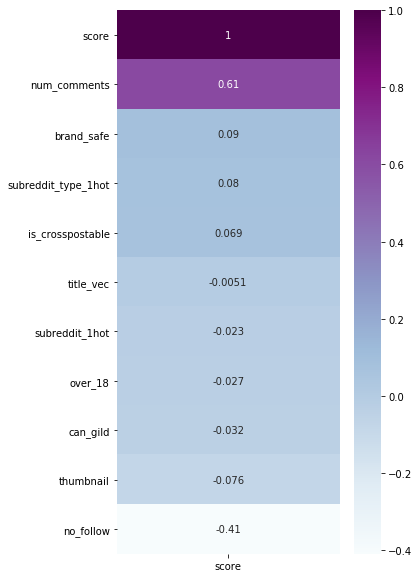

In [55]:
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
import matplotlib.pyplot as plt

# chooose the features to calculate correlation between them. Cannot calculte the correlation between hashing encoding features.
Variables_corr= ['score','brand_safe','can_gild','is_crosspostable','no_follow','num_comments','over_18','subreddit_type_1hot','thumbnail',
            'subreddit_1hot','title_vec']


def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    # use VectorAssembler to combine a given list of columns into a single vector column
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, 'pearson')
    # result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    array=matrix.select('pearson(corr_features)').collect()[0][0].values
    # pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)
    df_matrix=pd.DataFrame(array.reshape(-1,len(corr_columns))[0], index=corr_columns,columns=["score"])
    df_matrix=df_matrix.sort_values(by='score', ascending=False)
    return df_matrix  ### if we have 20 features, use 20 as columns
  
result_matrix=correlation_matrix(train_df2,Variables_corr)
# use SNS heatmap to show the correlation 
sns.heatmap(result_matrix,annot=True,cmap='BuPu')
fig=plt.gcf()
fig.set_size_inches(5,10)
plt.show()

In [56]:
# assemble inputs
assembler = VectorAssembler(
  inputCols=['brand_safe','can_gild','is_crosspostable','no_follow','num_comments','over_18','subreddit_type_1hot','thumbnail',
            'subreddit_1hot','title_vec'],
  outputCol='feature')

feature_df = assembler.transform(train_df2).select('feature','score')

# 3. Model Development

## 3.1. Linear regression

In [59]:
lr = LinearRegression(featuresCol='feature',labelCol='score',maxIter=200)

pipeline = Pipeline(stages=[lr])

paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.01,0.05,0.1,0.5,1,5,10]).build()
evaluator1 = RegressionEvaluator(predictionCol='prediction', labelCol='score',metricName='r2')
evaluator2 = RegressionEvaluator(predictionCol='prediction', labelCol='score',metricName='rmse')

crossval = CrossValidator(estimator=pipeline,estimatorParamMaps=paramGrid,evaluator=evaluator2,numFolds=5)
crossval.setCollectSubModels(True)
crossval_model = crossval.fit(feature_df)

train_pred_df = crossval_model.transform(feature_df)

lr_eval1 = evaluator1.evaluate(train_pred_df)
lr_eval2 = evaluator2.evaluate(train_pred_df)


print('Best model r2:',lr_eval1)
print('Best model rmse:',lr_eval2)

/databricks/spark/python/pyspark/ml/util.py:737: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
Best model r2: 0.4494386625196969
Best model rmse: 21.594214209123923

In [60]:
lr_bestParam = crossval_model.bestModel.stages[-1].extractParamMap()
lr_bestParam_dict = {}

for k, v in lr_bestParam.items():
  lr_bestParam_dict[k.name] = v

print('Best lr regularization coefficient:',lr_bestParam_dict['regParam'])

Best lr regularization coefficient: 0.5

## 3.2. Decision tree

In [62]:
dt = DecisionTreeRegressor(featuresCol = 'feature', labelCol='score')

#least to most allowable depth of tree (5~20)
max_depth_list = [5,10,15,20]

pipeline2 = Pipeline(stages=[dt])
paramGrid2 = ParamGridBuilder().addGrid(dt.maxDepth, max_depth_list).build()
crossval_dt = CrossValidator(estimator=pipeline2,estimatorParamMaps=paramGrid2,evaluator=evaluator2,numFolds=5)
crossval_model_dt = crossval_dt.fit(feature_df)

train_pred_df_dt = crossval_model_dt.transform(feature_df)

dt_eval1 = evaluator1.evaluate(train_pred_df_dt)
dt_eval2 = evaluator2.evaluate(train_pred_df_dt)

print('Best model Decision Tree r2:',dt_eval1)
print('Best model Decision Tree rmse:',dt_eval2)

Best model Decision Tree r2: 0.6399745766161847
Best model Decision Tree rmse: 17.462287527953404

In [63]:
dt_bestParam = crossval_model_dt.bestModel.stages[-1].extractParamMap()

dt_bestParam_dict = {}

for k, v in dt_bestParam.items():
  dt_bestParam_dict[k.name] = v

print('Best dt max depth:', dt_bestParam_dict['maxDepth'])

Best dt max depth: 5

## 3.3. Random forest

In [65]:
rf = RandomForestRegressor(featuresCol = 'feature', labelCol='score')

#least to most allowable depth of tree (5~15)
rf_max_depth_list = [5,10,15]
# candidate number of trees 
ntrees = [10,20]

pipeline3 = Pipeline(stages=[rf])
paramGrid3 = ParamGridBuilder().addGrid(rf.maxDepth, rf_max_depth_list).addGrid(rf.numTrees, ntrees).build()
crossval_rf = CrossValidator(estimator=pipeline3,estimatorParamMaps=paramGrid3,evaluator=evaluator2,numFolds=5)
crossval_model_rf = crossval_rf.fit(feature_df)

train_pred_df_rf = crossval_model_rf.transform(feature_df)

rf_eval1 = evaluator1.evaluate(train_pred_df_rf)
rf_eval2 = evaluator2.evaluate(train_pred_df_rf)

print('Best model Random Forest r2:', rf_eval1)
print('Best model Random Forest rmse:', rf_eval2)

Best model Random Forest r2: 0.6088830010722799
Best model Random Forest rmse: 18.200691812795053

In [66]:
rf_bestParam = crossval_model_rf.bestModel.stages[-1].extractParamMap()

rf_bestParam_dict = {}

for k, v in rf_bestParam.items():
  rf_bestParam_dict[k.name] = v

print('Best rf max depth:', rf_bestParam_dict['maxDepth'])
print('Best rf number of trees:', rf_bestParam_dict['numTrees'])

Best rf max depth: 5
Best rf number of trees: 20

# 4. Model testing

## 4.1. Preprocess test & oot datasets

In [69]:
# preprocess test dataset
test_df2 = test_df.drop('author','domain')
test_df2 = test_df2.drop('author_cakeday','author_flair_background_color','author_flair_css_class','author_flair_text','author_flair_text_color',
                         'distinguished','link_flair_css_class','link_flair_text','media','post_hint','preview','retrieved_on','secure_media',
                         'suggested_sort','thumbnail_height','thumbnail_width')
test_df2 = test_df2.drop('archived','author_flair_richtext','author_flair_type','contest_mode','edited','gilded','hidden','hide_score',
                          'is_reddit_media_domain','is_self','is_video','link_flair_richtext','link_flair_text_color','link_flair_type',
                          'locked','num_crossposts','rte_mode','send_replies','spoiler','stickied')
test_df2 = test_df2.drop('id','permalink','url','selftext','parent_whitelist_status','whitelist_status', 'created_utc')

test_df2 = subreddit_stringIndexer.transform(test_df2)
test_df2 = subreddit_encoder.transform(test_df2)
test_df2 = test_df2.drop('subreddit','subreddit_id','subreddit_name_prefixed','subreddit_index')

test_df2 = regexTokenizer.transform(test_df2)
test_df2 = remover.transform(test_df2)
test_df2 = word2Vec_model.transform(test_df2)
test_df2 = test_df2.drop('title','title_split','title_filtered')

test_df2 = test_df2.withColumn('brand_safe',when(col('brand_safe')==True,1).otherwise(0))
test_df2 = test_df2.withColumn('can_gild',when(col('can_gild')==True,1).otherwise(0))
test_df2 = test_df2.withColumn('is_crosspostable',when(col('is_crosspostable')==True,1).otherwise(0))
test_df2 = test_df2.withColumn('over_18',when(col('over_18')==True,1).otherwise(0))

test_df2 = subredditType_stringIndexer.transform(test_df2)
test_df2 = subredditType_encoder.transform(test_df2)
test_df2 = test_df2.drop('subreddit_type','subreddit_type_index')

test_df2 = test_df2.withColumn('thumbnail',when(col('thumbnail')=='default',0).otherwise(1))
test_df2 = test_df2.withColumn('no_follow',when(col('no_follow')==True,1).otherwise(0))

In [70]:
# preprocess oot dataset
oot_df2 = oot_df.drop('author','domain')
oot_df2 = oot_df2.drop('author_cakeday','author_flair_background_color','author_flair_css_class','author_flair_text','author_flair_text_color',
                         'distinguished','link_flair_css_class','link_flair_text','media','post_hint','preview','retrieved_on','secure_media',
                         'suggested_sort','thumbnail_height','thumbnail_width')
oot_df2 = oot_df2.drop('archived','author_flair_richtext','author_flair_type','contest_mode','edited','gilded','hidden','hide_score',
                          'is_reddit_media_domain','is_self','is_video','link_flair_richtext','link_flair_text_color','link_flair_type',
                          'locked','num_crossposts','rte_mode','send_replies','spoiler','stickied')
oot_df2 = oot_df2.drop('id','permalink','url','selftext','parent_whitelist_status','whitelist_status', 'created_utc')

oot_df2 = subreddit_stringIndexer.transform(oot_df2)
oot_df2 = subreddit_encoder.transform(oot_df2)
oot_df2 = oot_df2.drop('subreddit','subreddit_id','subreddit_name_prefixed','subreddit_index')

oot_df2 = regexTokenizer.transform(oot_df2)
oot_df2 = remover.transform(oot_df2)
oot_df2 = word2Vec_model.transform(oot_df2)
oot_df2 = oot_df2.drop('title','title_split','title_filtered')

oot_df2 = oot_df2.withColumn('brand_safe',when(col('brand_safe')==True,1).otherwise(0))
oot_df2 = oot_df2.withColumn('can_gild',when(col('can_gild')==True,1).otherwise(0))
oot_df2 = oot_df2.withColumn('is_crosspostable',when(col('is_crosspostable')==True,1).otherwise(0))
oot_df2 = oot_df2.withColumn('over_18',when(col('over_18')==True,1).otherwise(0))

oot_df2 = subredditType_stringIndexer.transform(oot_df2)
oot_df2 = subredditType_encoder.transform(oot_df2)
oot_df2 = oot_df2.drop('subreddit_type','subreddit_type_index')

oot_df2 = oot_df2.withColumn('thumbnail',when(col('thumbnail')=='default',0).otherwise(1))
oot_df2 = oot_df2.withColumn('no_follow',when(col('no_follow')==True,1).otherwise(0))

In [71]:
feature_test_df = assembler.transform(test_df2).select('feature','score')
feature_oot_df = assembler.transform(oot_df2).select('feature','score')

## 4.2. Test linear regression model

In [73]:
# linear regression model
# test dataset
test_lr_pred_df = crossval_model.transform(feature_test_df)
lr_eval1_test = evaluator1.evaluate(test_lr_pred_df)
lr_eval2_test= evaluator2.evaluate(test_lr_pred_df)

print('Best model test r2:',lr_eval1_test)
print('Best model test rmse:',lr_eval2_test)

# oot dataset
oot_lr_pred_df = crossval_model.transform(feature_oot_df)
lr_eval1_oot = evaluator1.evaluate(oot_lr_pred_df)
lr_eval2_oot = evaluator2.evaluate(oot_lr_pred_df)
print('Best model oot r2:',lr_eval1_oot)
print('Best model oot rmse:',lr_eval2_oot)

Best model test r2: 0.4396137528985462
Best model test rmse: 21.964158269781944
Best model oot r2: 0.21385459955272257
Best model oot rmse: 27.38629135206037

## 4.3. Test decision tree model

In [75]:
# Decision tree model
# test dataset
test_dt_pred_df = crossval_model_dt.transform(feature_test_df)
dt_eval1_test = evaluator1.evaluate(test_dt_pred_df)
dt_eval2_test= evaluator2.evaluate(test_dt_pred_df)

print('Best model test r2:',dt_eval1_test)
print('Best model test rmse:',dt_eval2_test)

# oot dataset
oot_dt_pred_df = crossval_model_dt.transform(feature_oot_df)
dt_eval1_oot = evaluator1.evaluate(oot_dt_pred_df)
dt_eval2_oot = evaluator2.evaluate(oot_dt_pred_df)
print('Best model oot r2:',dt_eval1_oot)
print('Best model oot rmse:',dt_eval2_oot)

Best model test r2: 0.4842512316547305
Best model test rmse: 21.07123206017072
Best model oot r2: 0.48846983968166213
Best model oot rmse: 22.091103370352684

## 4.4. Test random forest model

In [77]:
# Random forest model
# test dataset
test_rf_pred_df = crossval_model_rf.transform(feature_test_df)
rf_eval1_test = evaluator1.evaluate(test_rf_pred_df)
rf_eval2_test= evaluator2.evaluate(test_rf_pred_df)

print('Best model test r2:',rf_eval1_test)
print('Best model test rmse:',rf_eval2_test)

# oot dataset
oot_rf_pred_df = crossval_model_rf.transform(feature_oot_df)
rf_eval1_oot = evaluator1.evaluate(oot_rf_pred_df)
rf_eval2_oot = evaluator2.evaluate(oot_rf_pred_df)
print('Best model oot r2:',rf_eval1_oot)
print('Best model oot rmse:',rf_eval2_oot)

Best model test r2: 0.5804311033637574
Best model test rmse: 19.00520126639386
Best model oot r2: 0.5660634327111083
Best model oot rmse: 20.346743480223097

## 4.5. Compare training, test, oot performance

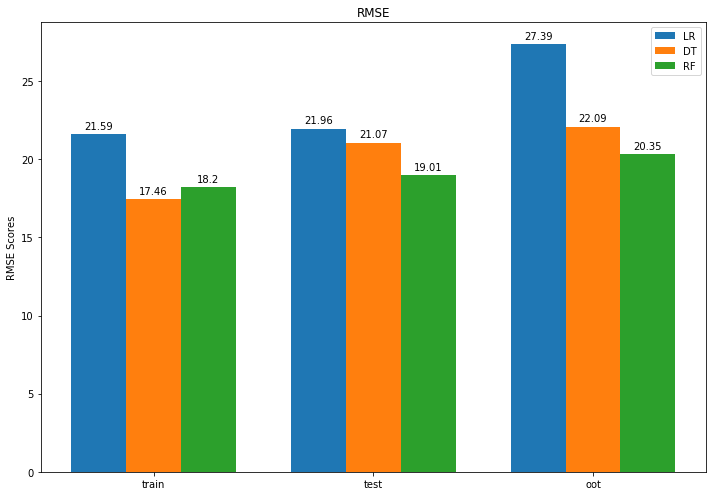

In [79]:
labels = ['train', 'test', 'oot']
LR_performance = np.around([lr_eval2,lr_eval2_test,lr_eval2_oot],2)
DT_performance = np.around([dt_eval2,dt_eval2_test,dt_eval2_oot],2)
RF_performance = np.around([rf_eval2,rf_eval2_test,rf_eval2_oot],2)

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width, LR_performance, width, label='LR')
rects2 = ax.bar(x, DT_performance, width, label='DT')
rects3 = ax.bar(x + width, RF_performance, width, label='RF')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE Scores')
ax.set_title('RMSE')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

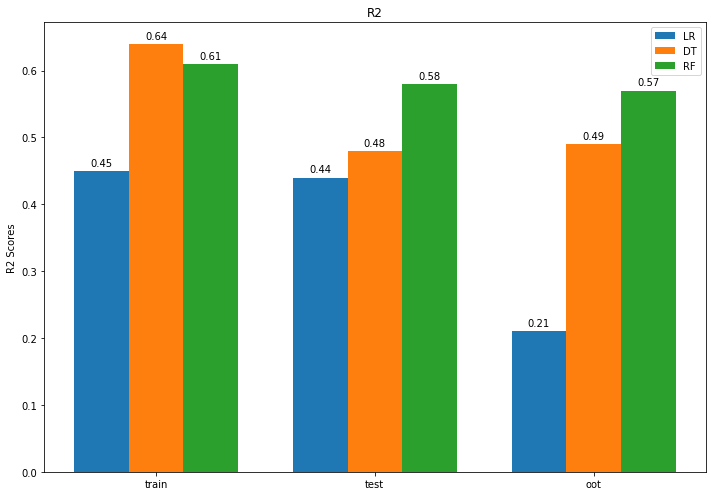

In [80]:
labels = ['train', 'test', 'oot']
LR_performance = np.around([lr_eval1,lr_eval1_test,lr_eval1_oot],2)
DT_performance = np.around([dt_eval1,dt_eval1_test,dt_eval1_oot],2)
RF_performance = np.around([rf_eval1,rf_eval1_test,rf_eval1_oot],2)

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width, LR_performance, width, label='LR')
rects2 = ax.bar(x, DT_performance, width, label='DT')
rects3 = ax.bar(x + width, RF_performance, width, label='RF')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('R2 Scores')
ax.set_title('R2')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()